# Interaction between nuisance models and Lya theory

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
## Set default plot size, as normally its a bit too small
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
from lace.emulator import gp_emulator
from cup1d.nuisance import mean_flux_model
from cup1d.nuisance import metal_model
from cup1d.likelihood import lya_theory
from lace.emulator import nn_emulator

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [2]:
emu_params=['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']
training_set = 'Cabayol23'
if(training_set):
    emulator_label = "Cabayol23"
    emu_path = "NNmodels/Cabayol23/Cabayol23.pt"
    drop_sim_val = None
    pre_trained = True
    use_GP=False
    
if(pre_trained):
    emulator = nn_emulator.NNEmulator(
        training_set=training_set,
        emulator_label=emulator_label,
        emu_params=emu_params,
        model_path=emu_path,
        drop_sim=drop_sim_val,
        train=False,
    )    
else:
    if use_GP:
        emulator=gp_emulator.GPEmulator(training_set=training_set,emu_params=emu_params)
    else:
        # these might be sub-optimal settings for the Nyx emulator
        emulator=nn_emulator.NNEmulator(training_set=training_set,emu_params=emu_params)

Selected training set from Cabayol23
Select emulator in Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Model loaded. No training needed


In [3]:
# construct two models for the mean flux, with different number of parameters
F_model_test=mean_flux_model.MeanFluxModel(ln_tau_coeff=[1,0,-0.1])
F_model_fid=mean_flux_model.MeanFluxModel()

In [4]:
# create default Lya theory with default mean flux model
zs=[2.0,3.0,4.0]
free_param_names=['ln_tau_0','ln_tau_1','ln_tau_2']
theory=lya_theory.Theory(zs=zs,emulator=emulator,free_param_names=free_param_names)

In [5]:
# access mean flux parameters
params=theory.F_model_fid.get_parameters()
Np=len(params)
# will create new param array and set values
like_params=[]
values=[0]*Np
values[0]=-0.05
values[-1]=0.15
print(values)
for ip in range(Np):
    par=params[ip].get_new_parameter(0.5)
    par.set_without_cube(values[ip])
    like_params.append(par)
    print(params[ip].info_str(all_info=True),par.info_str())

[-0.05, 0, 0.15]
ln_tau_0 = 0.0 , -0.4 , 0.4 ln_tau_0 = -0.05
ln_tau_1 = 0.0 , -1.6 , 1.6 ln_tau_1 = 0
ln_tau_2 = 0.0 , -1.6 , 1.6 ln_tau_2 = 0.15


In [6]:
igm_models=theory.get_igm_models(like_params)
F_model=igm_models['F_model']

Text(0.5, 1.0, 'Effective optical depth')

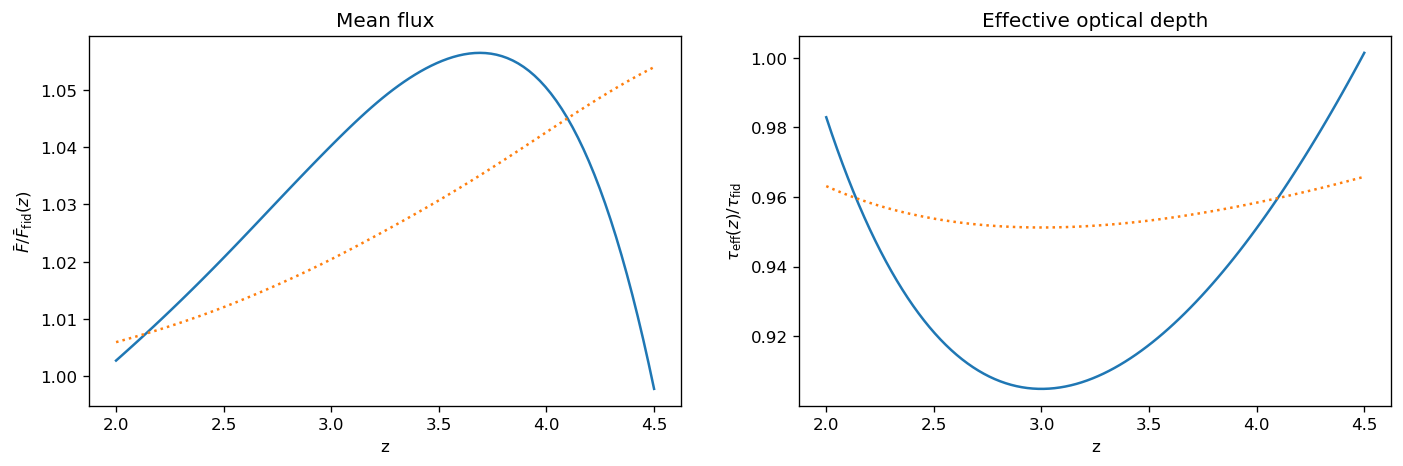

In [7]:
z=np.linspace(2.0,4.5,100)
plt.figure(figsize=[14,4])
# start with mean flux
plt.subplot(1, 2, 1)
plt.plot(z,F_model_test.get_mean_flux(z)/F_model_fid.get_mean_flux(z))
plt.plot(z,F_model.get_mean_flux(z)/F_model_fid.get_mean_flux(z),ls=':')
plt.xlabel('z')
plt.ylabel(r'$\bar{F} / \bar{F}_{\rm fid}(z)$')
plt.title('Mean flux')
# now effective optical depth
plt.subplot(1, 2, 2)
plt.plot(z,F_model_test.get_tau_eff(z)/F_model_fid.get_tau_eff(z))
plt.plot(z,F_model.get_tau_eff(z)/F_model_fid.get_tau_eff(z),ls=':')
plt.xlabel('z')
plt.ylabel(r'$\tau_{\rm eff}(z) / \tau_{\rm fid}$')
plt.title('Effective optical depth')

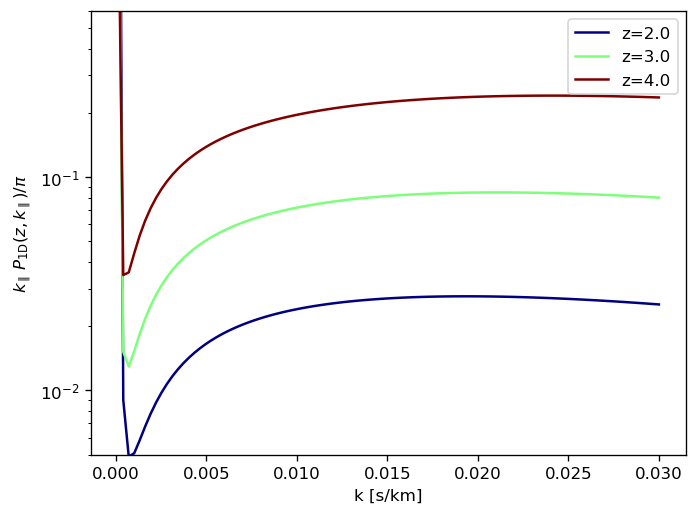

In [8]:
k_kms=np.linspace(0.0001,0.03,100)
theory.plot_p1d(k_kms,plot_every_iz=1)

## Play with metal model

In [9]:
# create default Lya theory with default mean flux model
free_param_names=['ln_tau_0','ln_tau_1','ln_tau_2','ln_SiIII_0']
theory_v1=lya_theory.Theory(zs=zs,emulator=emulator,free_param_names=free_param_names)

metal tag ln_SiIII


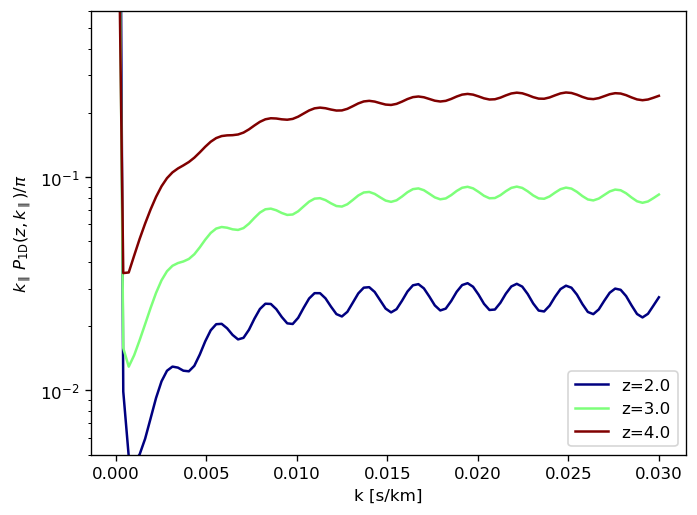

In [10]:
theory_v1.plot_p1d(k_kms,plot_every_iz=1)

In [11]:
metal_param=[p for p in theory_v1.get_parameters() if "ln_SiIII" in p.name][0]
print(metal_param.info_str(all_info=True))

ln_SiIII_0 = -4.509860006183766 , -20 , 0


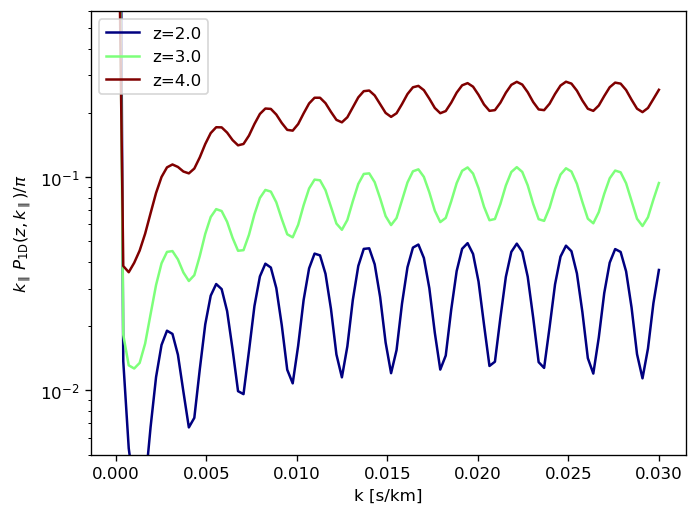

In [12]:
metal_param.value=-3
theory_v1.plot_p1d(k_kms,plot_every_iz=1,like_params=[metal_param])

In [13]:
# setup metal from metal_label
theory_v2=lya_theory.Theory(zs=zs,emulator=emulator,include_metals=['SiIII'])

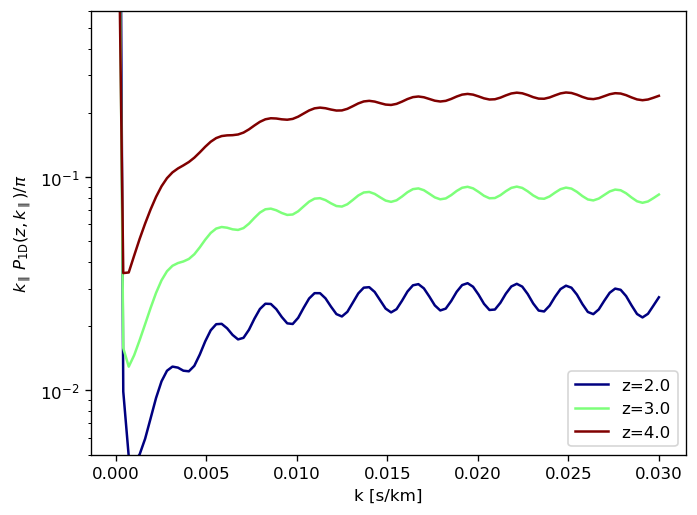

In [14]:
theory_v2.plot_p1d(k_kms,plot_every_iz=1)

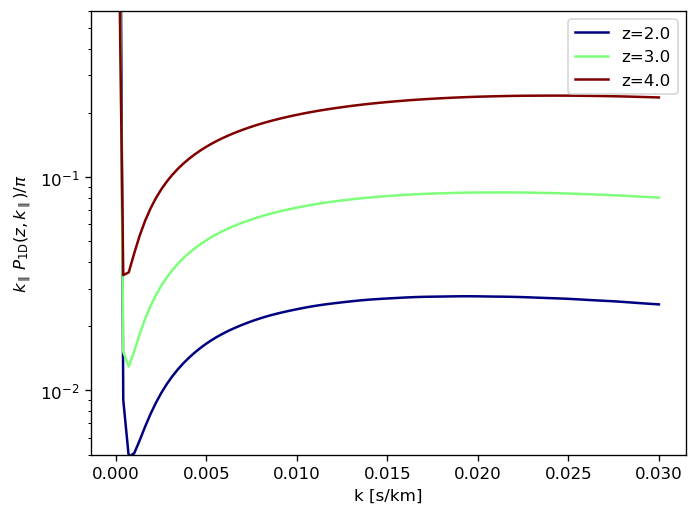

In [15]:
metal_param.value=-10
theory_v2.plot_p1d(k_kms,plot_every_iz=1,like_params=[metal_param])